In [21]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# A) Generate synthetic data with time-dependent alpha(t) = sin(t)
# ------------------------------------------------
key = jax.random.PRNGKey(42)

# We'll define alpha(t) = sin(t)
def beta_true(t):
    return jnp.sin(t)+1.0

x0 = 1.0   # initial condition
t_min, t_max = 0.0, 5.0
N_data = 50
t_data = jnp.linspace(t_min, t_max, N_data)

# Analytical solution for dx/dt = (sin(t)+1)*x(t), x(0)=1:
# x(t) = x0 * exp( \int_0^t sin(s) ds ) = exp(1 - cos(t))  if x0=1
def true_solution(t):
    return x0 * jnp.exp(1.0 - jnp.cos(t))

# Generate "true" data + noise
x_true = true_solution(t_data)
noise = 0.01 * jax.random.normal(key, shape=(N_data,))
x_data = x_true + noise




In [22]:

# ------------------------------------------------
# B) Define an MLP that outputs alpha(t)
# ------------------------------------------------
def glorot_init(key, shape):
    """Basic Xavier (Glorot) initialization."""
    k1, k2 = jax.random.split(key)
    fan_in, fan_out = shape
    limit = jnp.sqrt(6.0 / (fan_in + fan_out))
    return jax.random.uniform(k1, shape, minval=-limit, maxval=limit), k2

def init_mlp_params(key, sizes):
    """
    sizes = [in_dim, hidden1, hidden2, ..., out_dim].
    Returns a list of (W, b) for each layer.
    """
    params = []
    k = key
    for i in range(len(sizes) - 1):
        W_shape = (sizes[i], sizes[i+1])
        b_shape = (sizes[i+1],)
        W, k = glorot_init(k, W_shape)
        b = jnp.zeros(b_shape)
        params.append((W, b))
    return params

def mlp_forward(params, t):
    """
    Forward pass of the MLP that outputs alpha(t).
    We'll interpret 't' as a scalar -> jnp.array(t).
    Using tanh activation in hidden layers, no activation on final layer.
    """
    x = jnp.atleast_1d(t)  # ensure shape (1,) if t is scalar
    for (W, b) in params[:-1]:
        x = jnp.dot(x, W) + b
        x = jax.nn.tanh(x)
    # Final layer
    W, b = params[-1]
    x = jnp.dot(x, W) + b
    return x[0]  # scalar

# Suppose we use 1 hidden layer of 32 units: 1 -> 32 -> 1
mlp_sizes = [1, 32, 1]

# Initialize MLP parameters
key_init = jax.random.PRNGKey(0)
alpha_net_params = init_mlp_params(key_init, mlp_sizes)

# Helper function for evaluating alpha(t) from the MLP
def alpha_nn(params, t):
    return mlp_forward(params, t)



In [23]:

# ------------------------------------------------
# C) Numerically solve dx/dt = alpha_nn(t)*x(t)
#    using a simple Euler scheme for demonstration
# ------------------------------------------------
def euler_solve_ode(alpha_params, t_array, x0):
    """
    Forward-Euler integrator (simple demonstration).
    ODE: dx/dt = alpha_nn(t)*x(t).
    Integrates from t_array[0] to t_array[-1].
    Returns x(t) at each point in t_array.
    """
    t_array = jnp.sort(t_array)  # ensure ascending times

    # We store x(t) for each time in a scanned approach
    def step_fn(x_current, inputs):
        t_prev, t_next = inputs
        dt = t_next - t_prev
        # alpha at midpoint (simple approximation)
        t_mid = 0.5 * (t_prev + t_next)
        alpha_val = alpha_nn(alpha_params, t_mid)
        # forward Euler step
        x_next = x_current + dt * alpha_val * x_current
        return x_next, x_next

    # Create pairs [(t0, t1), (t1, t2), ...]
    times_pairs = jnp.stack([t_array[:-1], t_array[1:]], axis=-1)

    x0_final, x_traj = jax.lax.scan(step_fn, x0, times_pairs)

    # x_traj has shape (N-1,), missing the initial x0
    x_traj = jnp.concatenate([jnp.array([x0]), x_traj])
    return x_traj

# Evaluate x(t) at the same times as t_data
def solve_ode_at_t(alpha_params, t_eval, x0):
    return euler_solve_ode(alpha_params, t_eval, x0)



In [24]:
# ------------------------------------------------
# D) Define a data-only MSE loss
# ------------------------------------------------
def loss_fn_alpha_only(alpha_params, t_points, x_measured):
    # Numerically solve the ODE with alpha_nn(t)
    x_pred = solve_ode_at_t(alpha_params, t_points, x0)
    # MSE wrt data
    return jnp.mean((x_pred - x_measured)**2)

# We'll jit the loss for speed
@jit
def compute_loss(alpha_params):
    return loss_fn_alpha_only(alpha_params, t_data, x_data)

In [25]:

# ------------------------------------------------
# E) Train using Optax
# ------------------------------------------------
learning_rate = 1e-3
max_steps = 3000

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(alpha_net_params)

@jit
def train_step(alpha_params, opt_state):
    loss_value, grads = jax.value_and_grad(compute_loss)(alpha_params)
    updates, opt_state = optimizer.update(grads, opt_state, alpha_params)
    alpha_params = optax.apply_updates(alpha_params, updates)
    return alpha_params, opt_state, loss_value

loss_history = []
alpha_ref_history = []
#generate a sequence of timesteps to evaluate alpha(t) at
t_ref = jnp.linspace(t_min, t_max, 1000)
#initiate a matrix to store the alpha(t) values at every 500 timesteps
alpha_ref_all = []


for step in range(max_steps):
    alpha_net_params, opt_state, loss_value = train_step(alpha_net_params, opt_state)
    loss_history.append(float(loss_value))

    # Print occasionally
    if step % 500 == 0:
        print(f"Step {step}, Loss={loss_value:.6e}, alpha(1.0)={alpha_ref_val:.4f}")
        #evaluate alpha(t) at every time point in t_ref
        alpha_ref = vmap(alpha_nn, in_axes=(None, 0))(alpha_net_params, t_ref)
        print(alpha_ref.shape)
        #store alpha_ref values at every 500 timesteps alpha_ref_all
        alpha_ref_all.append(alpha_ref)



print("Training complete.")

Step 0, Loss=1.497077e+01, alpha(1.0)=0.9278
(1000,)
Step 500, Loss=4.413146e-01, alpha(1.0)=0.9278
(1000,)
Step 1000, Loss=2.884881e-01, alpha(1.0)=0.9278
(1000,)
Step 1500, Loss=1.702854e-01, alpha(1.0)=0.9278
(1000,)
Step 2000, Loss=8.028299e-02, alpha(1.0)=0.9278
(1000,)
Step 2500, Loss=3.265348e-02, alpha(1.0)=0.9278
(1000,)
Training complete.


In [26]:
alpha_ref_all = jnp.stack(alpha_ref_all, axis=1)
print(alpha_ref_all.shape)

(1000, 6)


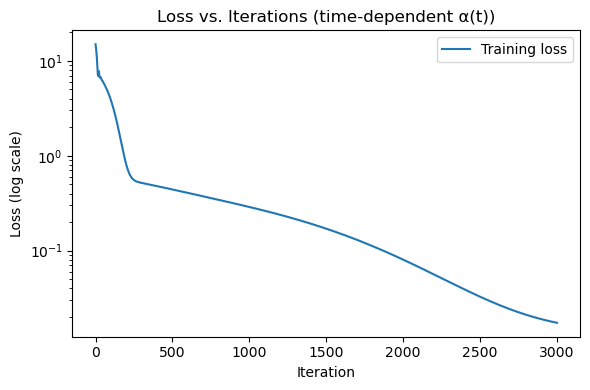

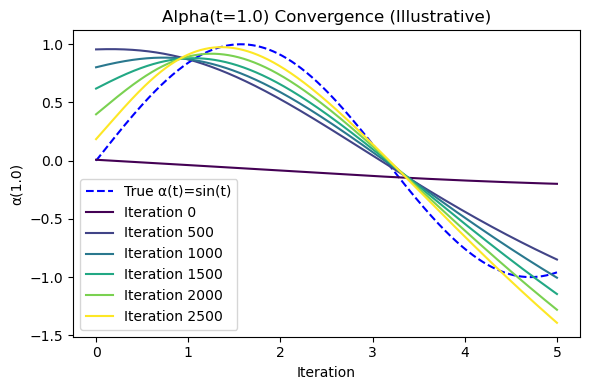

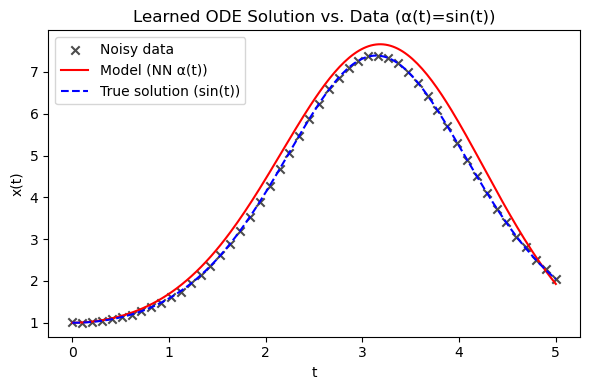


Final MSE (model vs true) = 8.742286e-02


In [27]:
# ------------------------------------------------
# F) Evaluate & Plot
# ------------------------------------------------
# Evaluate the trained model's solution on a dense grid
t_plot = jnp.linspace(t_min, t_max, 200)
x_model_plot = solve_ode_at_t(alpha_net_params, t_plot, x0)

# True solution on the same grid
x_true_plot = true_solution(t_plot)

# 1) Plot the training loss
plt.figure(figsize=(6,4))
plt.plot(loss_history, label="Training loss")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs. Iterations (time-dependent α(t))")
plt.legend()
plt.tight_layout()

# 2) plot the convergence of alpha recorded every 500 iterations in alpha_ref
plt.figure(figsize=(6,4))
# The true alpha(t) = sin(t) 
plt.plot(t_ref, jnp.sin(t_ref), 'b--', label="True α(t)=sin(t)")
# for every column in alpha_ref, plot the alpha(t) values, use different colors for each column
colors = plt.cm.viridis(jnp.linspace(0,1,alpha_ref_all.shape[1]))
for i in range(alpha_ref_all.shape[1]):
    plt.plot(t_ref, alpha_ref_all[:,i], color=colors[i], label=f"Iteration {i*500}")

plt.xlabel("Iteration")
plt.ylabel("α(1.0)")
plt.title("Alpha(t=1.0) Convergence (Illustrative)")
plt.legend()
plt.tight_layout()

# 3) Compare the final ODE solution with the data
plt.figure(figsize=(6,4))
plt.scatter(t_data, x_data, color='k', marker='x', alpha=0.7, label="Noisy data")
plt.plot(t_plot, x_model_plot, 'r-', label="Model (NN α(t))")
plt.plot(t_plot, x_true_plot, 'b--', label="True solution (sin(t))")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Learned ODE Solution vs. Data (α(t)=sin(t))")
plt.legend()
plt.tight_layout()

plt.show()

# Final MSE
final_mse = float(jnp.mean((x_model_plot - x_true_plot)**2))
print(f"\nFinal MSE (model vs true) = {final_mse:.6e}")
